In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
import random
import time

BOARD_WIDTH = 10
BOARD_HEIGHT = 20
BLANK = 0

TEMPLATE_WIDTH = 5
TEMPLATE_HEIGHT = 5

S_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '..OO.',
                     '.OO..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '...O.',
                     '.....']]

Z_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '.O...',
                     '.....']]

I_SHAPE_TEMPLATE = [['..O..',
                     '..O..',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     'OOOO.',
                     '.....',
                     '.....']]

O_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '.OO..',
                     '.....']]

J_SHAPE_TEMPLATE = [['.....',
                     '.O...',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..OO.',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '...O.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '.OO..',
                     '.....']]

L_SHAPE_TEMPLATE = [['.....',
                     '...O.',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '.O...',
                     '.....'],
                    ['.....',
                     '.OO..',
                     '..O..',
                     '..O..',
                     '.....']]

T_SHAPE_TEMPLATE = [['.....',
                     '..O..',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '..O..',
                     '.....']]

PIECES = {'S': S_SHAPE_TEMPLATE,
          'Z': Z_SHAPE_TEMPLATE,
          'J': J_SHAPE_TEMPLATE,
          'L': L_SHAPE_TEMPLATE,
          'I': I_SHAPE_TEMPLATE,
          'O': O_SHAPE_TEMPLATE,
          'T': T_SHAPE_TEMPLATE}

"""
Helper functions.
"""
def get_new_piece():
    # return a random new piece in a random rotation and color
    shape = random.choice(list(PIECES.keys()))
    new_piece = {'shape': shape,
                'rotation': random.randint(0, len(PIECES[shape]) - 1),
                'x': int(BOARD_WIDTH / 2) - int(TEMPLATE_WIDTH / 2),
                'y': -2, # start it above the board (i.e. less than 0)
                'color': random.randint(1, 10)}
    return new_piece

def get_blank_board():
    # create and return a new blank board data structure
    blank_board = []
    for i in range(BOARD_WIDTH):
        blank_board.append([BLANK] * BOARD_HEIGHT)
    return blank_board

def is_on_board(x, y):
    return x >= 0 and x < BOARD_WIDTH and y < BOARD_HEIGHT

"""
Tetris Environment Wrapper Class.
"""
class Env:
    def __init__(self):
        self.board = get_blank_board()
        self.falling_piece = get_new_piece()
        self.next_piece = get_new_piece()
        self.moving_down = False # note: there is no movingUp variable
        self.moving_left = False
        self.moving_right = False
        
    def one_step(self, action):
        state = (self.board, self.falling_piece, self.next_piece)
        if not self.is_valid_position(0, 0):
            # game is finished. Return
            return (state, 0, True)

        # reset moving_left, moving_right, moving_down to default value
        self.moving_left = False
        self.moving_right = False
        self.moving_down = False

        # moving the piece sideways
        if action == 'L' and self.is_valid_position(-1, 0):
            self.falling_piece['x'] -= 1
            self.moving_left = True
        elif action == 'R' and self.is_valid_position(1, 0):
            self.falling_piece['x'] += 1
            self.moving_right = True
        # rotating the piece (if there is room to rotate)
        elif action == 'W':
            self.falling_piece['rotation'] = (self.falling_piece['rotation'] + 1) % len(PIECES[self.falling_piece['shape']])
            if not self.is_valid_position(0, 0):
                self.falling_piece['rotation'] = (self.falling_piece['rotation'] - 1) % len(PIECES[self.falling_piece['shape']])
        elif action == 'Q': # rotate the other direction
            self.falling_piece['rotation'] = (self.falling_piece['rotation'] - 1) % len(PIECES[self.falling_piece['shape']])
            if not self.is_valid_position(0, 0):
                self.falling_piece['rotation'] = (self.falling_piece['rotation'] + 1) % len(PIECES[self.falling_piece['shape']])
        # making the piece fall faster with the down key
        elif action == 'D':
            self.moving_down = True
            if self.is_valid_position(0, 1):
                self.falling_piece['y'] += 1
        # move the current piece all the way down
        elif action == 'S':
            for i in range(1, BOARD_HEIGHT):
                if not self.is_valid_position(0, i):
                    break
            self.falling_piece['y'] += i - 1

        if not self.is_valid_position(0, 1):
            # falling piece has landed, set it on the board
            self.add_to_board(self.falling_piece)
            reward = self.remove_complete_lines()
            self.falling_piece = self.next_piece
            self.next_piece = get_new_piece()
        else:
            # piece did not land, just move the piece down
            self.falling_piece['y'] += 1
            reward = 0

        new_state = (self.board, self.falling_piece, self.next_piece)
        return (new_state, reward, False)

    def add_to_board(self, piece):
        # fill in the board based on piece's location, shape, and rotation
        for x in range(TEMPLATE_WIDTH):
            for y in range(TEMPLATE_HEIGHT):
                if PIECES[piece['shape']][piece['rotation']][y][x] != '.':
                    self.board[x + piece['x']][y + piece['y']] = piece['color']

    def is_valid_position(self, adjX, adjY):
        # Return True if the piece is within the board and not colliding
        for x in range(TEMPLATE_WIDTH):
            for y in range(TEMPLATE_HEIGHT):
                is_above_board = y + self.falling_piece['y'] + adjY < 0
                if is_above_board or PIECES[self.falling_piece['shape']][self.falling_piece['rotation']][y][x] == '.':
                    continue
                if not is_on_board(x + self.falling_piece['x'] + adjX, y + self.falling_piece['y'] + adjY):
                    return False
                if self.board[x + self.falling_piece['x'] + adjX][y + self.falling_piece['y'] + adjY] != BLANK:
                    return False
        return True

    def is_complete_line(self, x, y):
        # Return True if the line filled with boxes with no gaps.
        for x in range(BOARD_WIDTH):
            if self.board[x][y] == BLANK:
                return False
        return True

    def remove_complete_lines(self):
        # Remove any completed lines on the board, move everything above them down, and return the number of complete lines.
        num_lines_removed = 0
        y = BOARD_HEIGHT - 1 # start y at the bottom of the board
        while y >= 0:
            if self.is_complete_line(self.board, y):
                # Remove the line and pull boxes down by one line.
                for pull_down_Y in range(y, 0, -1):
                    for x in range(BOARD_WIDTH):
                        self.board[x][pull_down_Y] = self.board[x][pull_down_Y-1]
                # Set very top line to blank.
                for x in range(BOARD_WIDTH):
                    self.board[x][0] = BLANK
                num_lines_removed += 1
                # Note on the next iteration of the loop, y is the same.
                # This is so that if the line that was pulled down is also
                # complete, it will be removed.
            else:
                y -= 1 # move on to check next row up
        return num_lines_removed


In [3]:
def convert_state_to_img(env):
    def add_to_board_in_bound(board, piece):
        # fill in the board based on piece's location, shape, and rotation
        for x in range(TEMPLATE_WIDTH):
            for y in range(TEMPLATE_HEIGHT):
                if PIECES[piece['shape']][piece['rotation']][y][x] != '.' and y + piece['y'] >= 0:
                    board[x + piece['x']][y + piece['y']] = piece['color']
    board, falling_piece = env.board, env.falling_piece
    if falling_piece is None:
        return board
    blank = get_blank_board()
    add_to_board_in_bound(blank, falling_piece)
    for i in range(len(board)):
        for j in range(len(board[0])):
            blank[i][j] += board[i][j]
    return blank

def animate(env, actions):
    %matplotlib
    
    fig = plt.gcf()
    fig.show()
    fig.canvas.draw()
    plt.grid()
    
    for action in actions:
        time.sleep(0.2)
        
        state, reward, done = env.one_step(action)
        if done:
            break
        falling_piece_shape = state[1]['shape']
        next_piece_shape = state[2]['shape']
        
        plt.title('Action: ' + action +', Cur: '+falling_piece_shape+', Next: '+next_piece_shape)
        
        board = convert_state_to_img(env)

        plt.imshow(np.transpose(board), cmap=plt.cm.binary, interpolation='none')
        width = len(board)
        height = len(board[0])
        plt.xlim(-0.5, width-0.5)
        plt.ylim(height-0.5, 0.5)
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, width-0.5, 1))
        ax.set_yticks(np.arange(0.5, height-0.5, 1))
        
        fig.canvas.draw()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


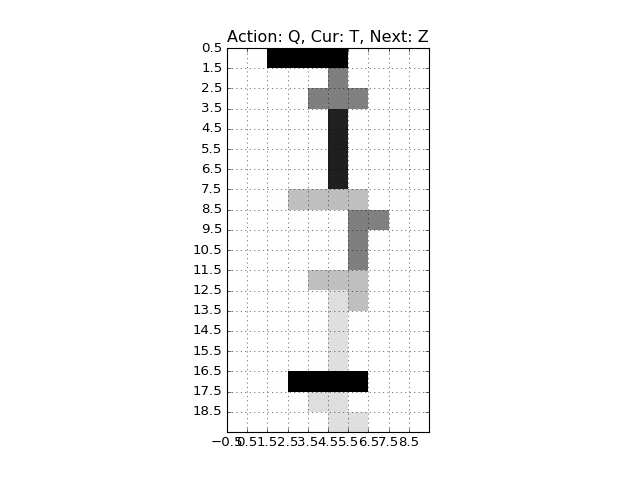

In [4]:
random.seed(2)
env = Env()
state, reward, done = (env.board, env.falling_piece, env.next_piece), 0, False
possible_actions = ['L', 'R', 'D', 'W', 'Q', 'S']
action_length = 100
actions = [possible_actions[random.randint(0, len(possible_actions)-1)] for _ in range(action_length)]

animate(env, actions)

In [5]:
plt.imshow(np.transpose(state[0]), cmap=plt.cm.binary, interpolation='none')
plt.show()